In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object

In [2]:
%autoreload 2   # something with pip install -e .

# Reading

In [3]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/Users/an/Documents/0_mfpt/repptis1/"
zero_minus_one = True
inputfile = indir + "/out.rst"
#inputfile = indir + "/retis.rst"

# new data Elias
#---------------
indir = "/Users/an/Documents/0_mfpt/elias/flat-no-walls/REPPTIS/"
#indir = "/Users/an/Documents/0_mfpt/elias/flat-no-walls/RETIS/"
zero_minus_one = True
indir = "/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/"
zero_minus_one = False
#indir = "/Users/an/Documents/0_mfpt/elias/cosbump2-walls/REPPTIS/"
#zero_minus_one = False
inputfile = indir + "/out.rst"

# old data bump An
#------------------
#indir = "/Users/an/wwork/current-work/0_TitusEnrico/repp/1D-flat.ppr-Febr6-2022d/"
##indir = "/Users/an/wwork/current-work/0_TitusEnrico/repp/bump-ppretis/"
#inputfile = indir + "/out.rst"

import os
import glob
os.chdir(indir)

folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

['/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/000', '/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/001', '/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/002', '/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/003', '/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/004']


In [4]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol[len(indir):])
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    #pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/Users/an/Documents/0_mfpt/elias/flat-w-walls/50k-cycles/REPPTIS/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ..., 49998, 49999, 50000]),
 'flags': array(['ACC', 'ACC', 'BTL', ..., 'ACC', 'BTL', 'BTL'], dtype='<U3'),
 'generation': array(['ki', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.08922184, -0.08137773, -0.10142089, ..., -0.08895494,
       -0.09672198, -0.10088395]),
 'lambmins': array([-0.105     , -0.10142089, -0.11016192, ..., -0.10088395,
       -0.10088395, -0.10473833]),
 'lengths': array([5, 3, 2, ..., 3, 2, 2]),
 'lmrs': array(['RMR', 'RMR', '***', ..., 'RMR', '*MR', '***'], dtype='<U3'),
 'name': '000',
 'ncycle': 50001,
 'newpathnumbers': array([    0,     1,     1, ..., 15351, 15351, 15351]),
 

# Analysis

In [5]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    if i != 1:
        print("Calculating path lengths.")
        set_tau_distrib(pathensembles[i])
        print("Done.")
    #else:
        #TODO problem with ...
    if i > 1:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")
    #else:
        # TODO problem with ....

0
Calculating path lengths.
Done.
1
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
NOT LAST
Done.


In [6]:
# Analyze the pptis simulation.
# Analysis output is saved to the data dictionary.
data = {}
for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    pathtypes = ("LML", "LMR", "RML", "RMR")
    pathtype_cycles = {}
    for ptype in pathtypes:
        pathtype_cycles[ptype] = unwrap_by_weight(
                (pe.lmrs == ptype).astype(int), pe.weights)
    
    # running average analysis: ["running"]
    data[i] = {}
    data[i]["running"] = {}
    data[i]["running"]["plocal"] = {}
    # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    for (ptype, p_loc) in zip(pathtypes, 
                              running_avg_local_probs(pathtype_cycles, 
                                                      pe.weights, tr = False)):
        data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
Weights of the different paths:
wRMR = 0
wRML = 4701
wLMR = 4412
wLML = 40888
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 0.09739514348785872
pLML = 0.9026048565121413
doing pathensemble 2
Weights of the different paths:
wRMR = 11810
wRML = 13385
wLMR = 12952
wLML = 11854
Local crossing probabilities:
pRMR = 0.468743798372693
pRML = 0.531256201627307
pLMR = 0.5221317423204064
pLML = 0.4778682576795936
doing pathensemble 3
Weights of the different paths:
wRMR = 11962
wRML = 13105
wLMR = 13124
wLML = 11810
Local crossing probabilities:
pRMR = 0.47720110104918817
pRML = 0.5227988989508118
pLMR = 0.5263495628459132
pLML = 0.4736504371540868
doing pathensemble 4
Weights of the different paths:
wRMR = 11931
wRML = 13431
wLMR = 12867
wLML = 11772
Local crossing probabilities:
pRMR = 0.47042819966879584
pRML = 0.5295718003312042
pLMR = 0.522220869353464
pLML = 0.477779130646536


/Users/an/opt/anaconda3/lib/python3.9/site-packages/tistools-0.1-py3.9.egg/tistools/repptis_analysis.py:555: RuntimeWarning: invalid value encountered in true_divide
/Users/an/opt/anaconda3/lib/python3.9/site-packages/tistools-0.1-py3.9.egg/tistools/repptis_analysis.py:556: RuntimeWarning: invalid value encountered in true_divide


In [7]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True


/Users/an/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/an/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/an/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/an/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/an/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Pcross with recursive relations

In [8]:
# Global crossing probabilities
# WITHOUT ERRORS #  
# Full data 
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)

This should be the same as the repptis_report.pdf value: 0.025934440580135998
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/var/folders/n7/pwfrkg556gn5m722jq91lq_h0000gn/T/ipykernel_5950/2475102732.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


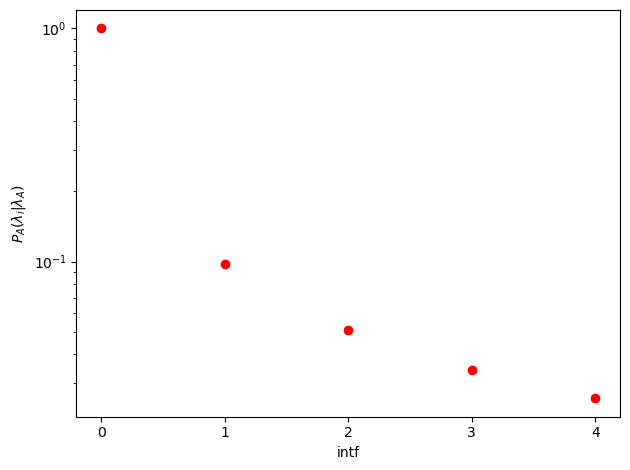

In [9]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")
ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [10]:
# TODO I am not sure what this is

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

This should be the same as the repptis_report.pdf value: 0.025934440580135998


# Now work with MSM

In [11]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import vector_G

In [12]:
def create_labels_states(N):
    assert N>=3
    labels1 = ["0-     ","B      "]
    labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR"]
    if N>3:
        for i in range(1,N-2):
            labels2.append(str(i)  +"+- RML")
            labels2.append(str(i)  +"+- RMR")
            labels2.append(str(i+1)+"+- LML")
            labels2.append(str(i+1)+"+- LMR")
    return labels1, labels2

def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [13]:
print(interfaces)
N = len(interfaces)
assert N >= 4
NS = 4*N-5
print("N", N)
print("len pmms", len(pmms))
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)

[-0.1, 0.0, 0.1, 0.2, 0.3]
N 5
len pmms 4
NS 15


In [14]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
M = construct_M(pmms, pmps, ppms, ppps, NS, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

mm [0.9026048565121413, 0.4778682576795936, 0.4736504371540868, 0.477779130646536]
mp [0.09739514348785872, 0.5221317423204064, 0.5263495628459132, 0.522220869353464]
pm [1.0, 0.531256201627307, 0.5227988989508118, 0.5295718003312042]
pp [0.0, 0.468743798372693, 0.47720110104918817, 0.47042819966879584]
sum [1. 1. 1. 1.]
sum [1. 1. 1. 1.]


In [15]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (15, 15)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0.         0.90260486 0.09739514 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.47786826 0.52213174
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.47365044 0.52634956 0.         0.
  0.       

# Look at this Markov model

In [16]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 1.00000000e+00+0.j         -1.00000000e+00+0.j
 -6.02227220e-01+0.j          6.02227220e-01+0.j
  1.18309315e-01+0.j         -1.18309315e-01+0.j
 -7.78430325e-17+0.15508846j -7.78430325e-17-0.15508846j
 -8.59230508e-09+0.j          8.59230673e-09+0.j
 -1.53660901e-16+0.j         -1.29675303e-15+0.j
  9.82269662e-17+0.j         -1.51915328e-19+0.j
  0.00000000e+00+0.j        ]
[ 1.00000000e+00+0.00000000e+00j -1.00000000e+00+0.00000000e+00j
  6.02227220e-01+0.00000000e+00j -6.02227220e-01+0.00000000e+00j
  9.10729825e-17+1.55088459e-01j  9.10729825e-17-1.55088459e-01j
 -1.18309315e-01+0.00000000e+00j  1.18309315e-01+0.00000000e+00j
  9.71445147e-17+9.17236146e-09j  9.71445147e-17-9.17236146e-09j
  9.96339507e-16+0.00000000e+00j -8.62289512e-16+0.00000000e+00j
  1.27781148e-16+0.00000000e+00j -2.89536280e-17+2.27378084e-17j
 -2.89536280e-17-2.27378084e-17j]


In [17]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0.90260486 0.         0.         0.         0.04654205 0.0508531
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
1.0
[0.         0.81469553 0.08790933 0.04654205 0.         0.
 0.         0.         0.02408659 0.0267665  0.         0.
 0.         0.         0.        ]
0.9999999999999999
[0.86123757 0.         0.         0.         0.04200908 0.04590025
 0.01279615 0.01129044 0.         0.         0.         0.
 0.01278848 0.01397803 0.        ]
1.0
[0.         0.77735722 0.08388036 0.05480523 0.         0.
 0.         0.         0.0270884  0.0301023  0.0066858  0.00610268
 0.         0.         0.01397803]
1.0
[0.84614047 0.         0.         0.         0.04008376 0.0437966
 0.01794275 0.01583145 0.         0.         0.         0.
 0.01729798 0.01890699 0.        ]
0.9999999999999999
[0.         0.7637305  0.08240997 0.05802651 0.         0.
 0.         0.         0.02824285 0.03138519 0.00904336 0.008254

# Pcross with MSM

In [18]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 0.26628063424301013
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.5099874469604778
state 1+- RML 0.0
state 1+- RMR 0.5099874469604778
state 2+- LML 0.23905345301064668
state 2+- LMR 0.7537950108546798
state 2+- RML 0.2390534530106467
state 2+- RMR 0.7537950108546798
state 3+- LML 0.48468869116959373
state 3+- LMR 1.0
Y
state 0-      0.025934440580135998
state B       0.0
state 0+- LML 0.0
state 0+- LMR 0.26628063424301013
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 0.5099874469604778
state 1+- RML 0.0
state 1+- RMR 0.5099874469604778
state 2+- LML 0.23905345301064668
state 2+- LMR 0.7537950108546798
state 2+- RML 0.23905345301064668
state 2+- RMR 0.7537950108546798
state 3+- LML 0.4846886911695937
state 3+- LMR 1.0
global crossing prob [0.02593444]


# Collecting times

In [19]:
#TODO I need data too?

In [20]:
def collect_tau(pathensembles, data):
    # pathensembles -- list of pathensemble instances
    
    print("Collect tau")
    
    # average path lengths
    taumm = np.zeros(len(pathensembles))
    taump = np.zeros(len(pathensembles))
    taupm = np.zeros(len(pathensembles))
    taupp = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        print("ensemble", i, pathensembles[i].name)
        taumm[i] = pathensembles[i].tauavg['LML']-2
        taump[i] = pathensembles[i].tauavg['LMR']-2
        taupm[i] = pathensembles[i].tauavg['RML']-2
        taupp[i] = pathensembles[i].tauavg['RMR']-2

    # for [0-] (i=0)
    print("ensemble", 0, pathensembles[0].name)
    if pe.has_zero_minus_one:
        # TODO pieces missing
        taumm[0] = pathensembles[0].tauavg['LML']-2
        taump[0] = pathensembles[0].tauavg['LMR']-2
        taupm[0] = pathensembles[0].tauavg['RML']-2
        taupp[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1)
    print("ensemble", 1, pathensembles[1].name)
    taumm[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    taump[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    taupm[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    #taupp[1] = data[1]["pathlengths"]["RMR"]["mean"] - 2

    return taumm, taump, taupm, taupp

# this is the same:
# 1) after:
#   data[2]["pathlengths"] = pathlength_distr(upe)  # use correct upe!
#   This gives the whole distrib, mean, std, etc
#   print(data[2]["pathlengths"]["RMR"]["mean"])
# 2) after:
#   set_tau_distrib(pathensembles[2])
#   print(pathensembles[2].tauavg['RMR'])

# TODO for [0-]
# likely not okay yet, what about L*L etc??????
# There are paths missing TODO!!!!!!!! when lambda-1

In [21]:
# TODO fix +-1 issues!!!!!!
# TODO tau1 is not fool proof if you have too many phase points!!

def collect_tau1(pathensembles, data):
    # average path lengths, but only the part before the 1st crossing
    #---------------------------
    print("Collect tau1")
    taumm1 = np.zeros(len(pathensembles))
    taump1 = np.zeros(len(pathensembles))
    taupm1 = np.zeros(len(pathensembles))
    taupp1 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm1[i] = pathensembles[i].tau1avg['LML'] - 1
        taump1[i] = pathensembles[i].tau1avg['LMR'] - 1
        taupm1[i] = pathensembles[i].tau1avg['RML'] - 1
        taupp1[i] = pathensembles[i].tau1avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML
    taupm1[1] = data[1]["pathlengths"]["RML"]["mean"] - 2
    
    return taumm1, taump1, taupm1, taupp1

def collect_tau2(pathensembles, data):
    # average path lengths, but only the part after the last crossing
    #---------------------------
    print("Collect tau2")
    taumm2 = np.zeros(len(pathensembles))
    taump2 = np.zeros(len(pathensembles))
    taupm2 = np.zeros(len(pathensembles))
    taupp2 = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        taumm2[i] = pathensembles[i].tau2avg['LML'] - 1
        taump2[i] = pathensembles[i].tau2avg['LMR'] - 1
        taupm2[i] = pathensembles[i].tau2avg['RML'] - 1
        taupp2[i] = pathensembles[i].tau2avg['RMR'] - 1
    # for [0-] (i=0) -> just 0
    # for [0+-] (i=1) LML -> just 0
    # for [0+-] (i=1) LMR
    taump2[1] = data[1]["pathlengths"]["LMR"]["mean"] - 2
    # for [0+-] (i=1) RML -> just 0
    
    return taumm2, taump2, taupm2, taupp2

def collect_taum(pathensembles, data):
    # average path lengths, but only the part between first/last crossing
    #---------------------------
    print("Collect taum")
    taumm_m = np.zeros(len(pathensembles))
    taump_m = np.zeros(len(pathensembles))
    taupm_m = np.zeros(len(pathensembles))
    taupp_m = np.zeros(len(pathensembles))
    
    # for [1+-] and higher (i>=2)
    for i in range(2,len(pathensembles)):
        #print("ensemble", i, pathensembles[i].name)
        taumm_m[i] = pathensembles[i].tauavg['LML'] \
                   - pathensembles[i].tau1avg['LML'] \
                   - pathensembles[i].tau2avg['LML']
        taump_m[i] = pathensembles[i].tauavg['LMR'] \
                   - pathensembles[i].tau1avg['LMR'] \
                   - pathensembles[i].tau2avg['LMR']
        taupm_m[i] = pathensembles[i].tauavg['RML'] \
                   - pathensembles[i].tau1avg['RML'] \
                   - pathensembles[i].tau2avg['RML']
        taupp_m[i] = pathensembles[i].tauavg['RMR'] \
                   - pathensembles[i].tau1avg['RMR'] \
                   - pathensembles[i].tau2avg['RMR']

    # for [0-] (i=0)
    if pe.has_zero_minus_one:
        # TODO there are more paths!!!
        taumm_m[0] = pathensembles[0].tauavg['LML']-2
        taump_m[0] = pathensembles[0].tauavg['LMR']-2
        taupm_m[0] = pathensembles[0].tauavg['RML']-2
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2
    else:
        taupp_m[0] = pathensembles[0].tauavg['RMR']-2

    # for [0+-] (i=1) LML
    taumm_m[1] = data[1]["pathlengths"]["LML"]["mean"] - 2
    # for [0+-] (i=1) LMR -> just 0
    # for [0+-] (i=1) RML -> just 0

    return taumm_m, taump_m, taupm_m, taupp_m


In [22]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [23]:
taumm, taump, taupm, taupp = collect_tau(pathensembles, data)
taumm1, taump1, taupm1, taupp1 = collect_tau1(pathensembles, data)
taumm2, taump2, taupm2, taupp2 = collect_tau2(pathensembles, data)
taumm_m, taump_m, taupm_m, taupp_m = collect_taum(pathensembles, data)

Collect tau
ensemble 2 002
ensemble 3 003
ensemble 4 004
ensemble 0 000
ensemble 1 001
Collect tau1
Collect tau2
Collect taum


In [24]:
print("tau")
print_all_tau(pathensembles, taumm, taump, taupm, taupp)
print("\ntau1")
print_all_tau(pathensembles, taumm1, taump1, taupm1, taupp1)
print("\ntau_m")
print_all_tau(pathensembles, taumm_m, taump_m, taupm_m, taupp_m)
print("\ntau2")
print_all_tau(pathensembles, taumm2, taump2, taupm2, taupp2)

tau
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0          63.5
1 001            9.5          50.2          49.0           0.0
2 002          193.5         183.2         181.7         195.0
3 003          192.6         184.1         183.2         191.8
4 004          190.6         181.7         178.9         191.5

tau1
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0           0.0
1 001            0.0           0.0          49.0           0.0
2 002           50.1          49.4          49.5          50.5
3 003           50.2          49.8          49.6          50.6
4 004           50.0          49.6          50.2          51.0

tau_m
                  mm            mp            pm            pp
0 000            0.0           0.0           0.0          63.5
1 001            9.5           0.0           0.0           0.0
2 002           93.1          83.7    

In [25]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=4
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [26]:
tau  = construct_tau_vector(N, NS, taumm, taump, taupm, taupp)
tau1 = construct_tau_vector(N, NS, taumm1, taump1, taupm1, taupp1)
taum = construct_tau_vector(N, NS, taumm_m, taump_m, taupm_m, taupp_m)
tau2 = construct_tau_vector(N, NS, taumm2, taump2, taupm2, taupp2)
tau_m = tau-tau1-tau2  # yes, this is the same thing

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

tau
[ 63.45321094   9.46194482  50.18132366  48.95341417 193.49544458
 183.21564237 181.72842734 195.04276037 192.55165114 184.0532612
 183.1943533  191.79685671 190.625807   181.68267661   0.        ]


tau1
[ 0.          0.          0.         48.95341417 50.06310106 49.39731316
 49.50011207 50.45224386 50.18653683 49.80272783 49.61732163 50.55718107
 49.99974516 49.58047719  0.        ]
taum
[63.45321094  9.46194482  0.          0.         93.10772735 83.6695491
 82.05648114 94.37451312 92.57815411 83.41626029 82.90629531 91.90361144
 90.19011213 81.69184736  0.        ]
tau2
[ 0.          0.         50.18132366  0.         50.32461616 50.14878011
 50.17183414 50.21600339 49.7869602  50.83427309 50.67073636 49.3360642
 50.43594971 50.41035206  0.        ]


tau = tau1+taum+tau2 => difference is 2.524354896707238e-28


# Compute tau for [0+]

In [27]:
g1, g2, h1, h2 = vector_G(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 9.461944824887498
state 0+- LMR 461.21100825774704
state 0+- RML 0.0
state 1+- LML 143.43234351273833
state 1+- LMR 655.9415809190699
state 1+- RML 132.2283152782966
state 1+- RMR 666.7137682149357
state 2+- LML 525.130170972673
state 2+- LMR 519.4173909469614
state 2+- RML 516.3420883300687
state 2+- RMR 526.4065332125152
state 3+- LML 661.7709143510791
state 3+- LMR 132.10219942488536
H
state 0-      53.46010967843664
state B       0.0
state 0+- LML 0.0
state 0+- LMR 461.21100825774704
state 0+- RML 0.0
state 1+- LML 50.3246161633204
state 1+- LMR 572.2720318146846
state 1+- RML 50.17183414269705
state 1+- RMR 572.339255090465
state 2+- LML 432.55201686598366
state 2+- LMR 436.0011306604634
state 2+- RML 433.4357930229339
state 2+- RMR 434.5029217763007
state 3+- LML 571.5808022206
state 3+- LMR 50.410352063418046
interesting
[53.46010968]


In [28]:
print(h1[0])

[53.46010968]


# Flux

In [29]:
flux = 1/(tau[0]+h1[0])
dt = 0.0002
flux
print(flux/dt, "1/time")

[42.76672644] 1/time
